<a href="https://colab.research.google.com/github/boom-10/deep_study_se/blob/main/dog%26%26cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import json


# 判断是否存在GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())


Using gpu: True 


In [ ]:
! wget http://fenggao-image.stor.sinaapp.com/dogscats.zip
! unzip dogscats.zip

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

data_dir = './dogscats'

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'valid']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_classes = dsets['train'].classes

In [6]:
print(dsets['train'].classes)
print(dsets['train'].class_to_idx)
print(dsets['train'].imgs[:5])
print('dset_sizes: ', dset_sizes)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
[('./dogscats/train/cats/cat.0.jpg', 0), ('./dogscats/train/cats/cat.1.jpg', 0), ('./dogscats/train/cats/cat.10.jpg', 0), ('./dogscats/train/cats/cat.100.jpg', 0), ('./dogscats/train/cats/cat.101.jpg', 0)]
dset_sizes:  {'train': 1800, 'valid': 2000}


In [7]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)


'''
valid 数据一共有2000张图，每个batch是5张，因此，下面进行遍历一共会输出到 400
同时，把第一个 batch 保存到 inputs_try, labels_try，分别查看
'''
count = 1
for data in loader_valid:
    print(count, end='\n')
    if count == 1:
        inputs_try,labels_try = data
    count +=1

print(labels_try)
print(inputs_try.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

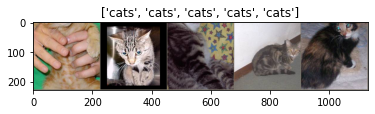

In [9]:
out = torchvision.utils.make_grid(inputs_try)
imshow(out, title=[dset_classes[x] for x in labels_try])

In [10]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-10-20 14:36:42--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.242.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.242.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2022-10-20 14:36:43 (400 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor([[-0.4730, -1.5262, -0.4488,  ...,  1.6461,  2.5510,  1.5779],
        [-1.7326,  1.7891, -0.1167,  ..., -6.8387,  4.8493,  4.9723],
        [-1.5109, -1.2515, -2.2347,  ..., -1.3995,  0.8583,  3.0607],
        [-0.8986,  0.3743,  2.1464,  ..., -6.7175,  0.0272,  5.0978],
        [-3.2942, -1.8620, -4.8029,  ..., -3.5904,  1.0021,  2.1484]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([5, 1000])
prob sum:  tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)
vals_try:  tensor([0.1646, 0.6553, 0.6649, 0.9326, 0.4207], device='cuda:0',
       grad_fn=<MaxBackward0>)
pred_try:  tensor([568, 281, 281, 281, 283], device='cuda:0')
['fur_coat', 'tabby', 'tabby', 'tabby', 'Persian_cat']


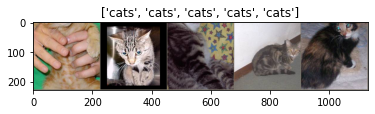

In [11]:
model_vgg = models.vgg16(pretrained=True)

with open('./imagenet_class_index.json') as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_vgg = model_vgg.to(device)

outputs_try = model_vgg(inputs_try)

print(outputs_try)
print(outputs_try.shape)

'''
可以看到结果为5行，1000列的数据，每一列代表对每一种目标识别的结果。
但是我也可以观察到，结果非常奇葩，有负数，有正数，
为了将VGG网络输出的结果转化为对每一类的预测概率，我们把结果输入到 Softmax 函数
'''
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,pred_try = torch.max(probs,dim=1)

print( 'prob sum: ', torch.sum(probs,1))
print( 'vals_try: ', vals_try)
print( 'pred_try: ', pred_try)

print([dic_imagenet[i] for i in pred_try.data])
imshow(torchvision.utils.make_grid(inputs_try.data.cpu()), 
       title=[dset_classes[x] for x in labels_try.data.cpu()])

In [12]:
print(model_vgg)

model_vgg_new = model_vgg;

for param in model_vgg_new.parameters():
    param.requires_grad = False
model_vgg_new.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg_new.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

model_vgg_new = model_vgg_new.to(device)

print(model_vgg_new.classifier)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
'''
第一步：创建损失函数和优化器

损失函数 NLLLoss() 的 输入 是一个对数概率向量和一个目标标签. 
它不会为我们计算对数概率，适合最后一层是log_softmax()的网络. 
'''
criterion = nn.NLLLoss()

# 学习率
lr = 0.001

# 随机梯度下降
optimizer_vgg = torch.optim.SGD(model_vgg_new.classifier[6].parameters(),lr = lr)

'''
第二步：训练模型
'''

def train_model(model,dataloader,size,epochs=1,optimizer=None):
  model.train()  #用于模型训练
  
  for epoch in range(epochs):
    epoch_acc_max = 0
    running_loss = 0.0
    running_corrects = 0
    count = 0

    for inputs,classes in dataloader:
      inputs = inputs.to(device)
      classes = classes.to(device)
            
      outputs = model(inputs)	#参数前向传播
            
      loss = criterion(outputs,classes)           
      optimizer = optimizer
      optimizer.zero_grad()	#优化器梯度初始化
      loss.backward()			#梯度反向传播
      optimizer.step()
      _,preds = torch.max(outputs.data,1) #得到预测结果
        # statistics
      running_loss += loss.data.item()
      running_corrects += torch.sum(preds == classes.data)
                    
      count += len(inputs)
      print('Training: No. ', count, ' process ... total: ', size)
            
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
        
    if epoch_acc > epoch_acc_max:
	    epoch_acc_max = epoch_acc
	    torch.save(model, 'model_best.pth')	#保存最好模型
        
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
        
        
# 模型训练
train_model(model_vgg_new, loader_train,size = dset_sizes['train'], 
		epochs = 5, optimizer=optimizer_vgg)

Training: No.  64  process ... total:  1800
Training: No.  128  process ... total:  1800
Training: No.  192  process ... total:  1800
Training: No.  256  process ... total:  1800
Training: No.  320  process ... total:  1800
Training: No.  384  process ... total:  1800
Training: No.  448  process ... total:  1800
Training: No.  512  process ... total:  1800
Training: No.  576  process ... total:  1800
Training: No.  640  process ... total:  1800
Training: No.  704  process ... total:  1800
Training: No.  768  process ... total:  1800
Training: No.  832  process ... total:  1800
Training: No.  896  process ... total:  1800
Training: No.  960  process ... total:  1800
Training: No.  1024  process ... total:  1800
Training: No.  1088  process ... total:  1800
Training: No.  1152  process ... total:  1800
Training: No.  1216  process ... total:  1800
Training: No.  1280  process ... total:  1800
Training: No.  1344  process ... total:  1800
Training: No.  1408  process ... total:  1800
Trai

In [ ]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
        # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
        print('Testing: No. ', i, ' process ... total: ', size)        
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes
  
predictions, all_proba, all_classes = test_model(model_vgg_new,loader_valid,size=dset_sizes['valid'])

Testing: No.  5  process ... total:  2000
Testing: No.  10  process ... total:  2000
Testing: No.  15  process ... total:  2000
Testing: No.  20  process ... total:  2000
Testing: No.  25  process ... total:  2000
Testing: No.  30  process ... total:  2000
Testing: No.  35  process ... total:  2000
Testing: No.  40  process ... total:  2000
Testing: No.  45  process ... total:  2000
Testing: No.  50  process ... total:  2000
Testing: No.  55  process ... total:  2000
Testing: No.  60  process ... total:  2000
Testing: No.  65  process ... total:  2000
Testing: No.  70  process ... total:  2000
Testing: No.  75  process ... total:  2000
Testing: No.  80  process ... total:  2000
Testing: No.  85  process ... total:  2000
Testing: No.  90  process ... total:  2000
Testing: No.  95  process ... total:  2000
Testing: No.  100  process ... total:  2000
Testing: No.  105  process ... total:  2000
Testing: No.  110  process ... total:  2000
Testing: No.  115  process ... total:  2000
Testing:

random correct idx:  [  19  152  795  499 1583  777 1128 1250]


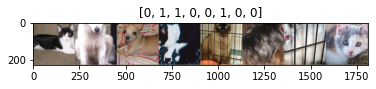

In [ ]:
# 单次可视化显示的图片个数
n_view = 8
correct = np.where(predictions==all_classes)[0]
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]
print('random correct idx: ', idx)
loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],
                  batch_size = n_view,shuffle=True)
for data in loader_correct:
    inputs_cor,labels_cor = data
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_cor)
imshow(out, title=[l.item() for l in labels_cor])

# 类似的思路，可以显示错误分类的图片，这里不再重复代码

In [ ]:
#不知道为什么/content/cat_dog/test就报错
dsets = datasets.ImageFolder('/content/cat_dog', vgg_format) 

final = {} #结果数组

loader_test = torch.utils.data.DataLoader(dsets, batch_size=1, shuffle=False, num_workers=0)

model_vgg_new = torch.load("/content/model_best.pth")

def test(model,dataloader,size):
    model.eval()	#参数固定

    cnt = 0	#count
    for inputs,_ in dataloader:
      if cnt < size:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1) #预测值最大化
        key = dsets.imgs[cnt][0].split("/")[-1].split('.')[0] #对目录项进行分割
        final[key] = preds[0]
        cnt += 1
      else:
        break;
test(model_vgg_new,loader_test,size=2000)

with open("/content/cat&&dog.csv",'a+') as f:
    for key in range(2000):
        f.write("{},{}\n".format(key,final[str(key)]))
